In [ ]:
!pip install opencv-python


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
from google.colab.patches import cv2_imshow

class BoundaryDetector:

    def __init__(self, imagepath):
        self.image = cv2.imread(imagepath)
        pass


    def k_means_image(self, image, k):
        bimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pixel_values = bimage.reshape((-1, 3))
        pixel_values = np.float32(pixel_values)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.2)
        _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        centers = np.uint8(centers)
        labels = labels.flatten()
        segmented_image = centers[labels.flatten()]
        segmented_image = segmented_image.reshape(bimage.shape)
        return segmented_image

    def random_color(self):
        color = list(np.random.choice(range(256), size=3))
        return tuple(color)

    def denoised_contour(self, with_coloring = False):
        dst = cv2.fastNlMeansDenoisingColored(self.image, None, 10, 10, 7, 15) 
        imgray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(imgray, 127, 255, 0)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        lined_image = cv2.drawContours(self.image, contours[2], -1, (0,255,0), 3)
        if with_coloring:
            lined_image = cv2.fillPoly(self.image, pts=contours, color = (50,251,55))
        return lined_image

    def binary_contour(self, with_k=False, k=2, with_coloring = False):
        contours = []
        if not with_k: 
            imgray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
            ret, thresh = cv2.threshold(imgray, 127, 255, 0)
            contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            lined_image = cv2.drawContours(self.image, contours, -1, (0,255,0), 3)
        else:
            dst = cv2.fastNlMeansDenoisingColored(self.image, None, 10, 10, 7, 15) 
            segmented_image = self.k_means_image(dst, k)
            imgray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
            ret, thresh = cv2.threshold(imgray, 127, 255, 0)
            contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            lined_image = cv2.drawContours(self.image, contours, -1, (0,np.random.randint(255),0), 3) #segd or w/e is the image to display on
        #Fill boundaries with different colors
        if with_coloring:
            lined_image = cv2.fillPoly(self.image, pts = contours, color = (50,251,55))
        return lined_image, contours
    #return contours, then color in, implement soon.


    def denoise(self):
        return cv2.fastNlMeansDenoisingColored(self.image, None, 10, 10, 7, 15)

    def process_contours(self, contours):
        areas = []
        for cnt in contours:
            areas.append(cv2.contourArea(cnt))
        sareas = sorted(areas)
        heuristic = sareas[len(areas)-8:len(areas)-1][0]
        passing_cnts = []
        for cnt in contours:
            if cv2.contourArea(cnt) > heuristic:
                print(cv2.contourArea(cnt))
                passing_cnts.append(cnt)
        #image = cv2.bitwise_and(self.image, self.image, mask=mask)
        return passing_cnts

    def bound_regions(self):
        clustered = self.k_means_image(self.denoise(), 3)
        imgray = cv2.cvtColor(clustered, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(imgray, 127, 255, 0)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        processed_contours = self.process_contours(contours)
        bounded_image = cv2.drawContours(self.image, processed_contours, -1, (0, 255, 0), 3)
        return bounded_image, processed_contours

    def in_bounds(self, bounds, x, y):
        for bound in bounds:
            if cv2.pointPolygonTest(bound,(x, y),True) > 0:
                return True
        return False

    def mask(self, bounds):
        h = self.image.shape[0]
        w = self.image.shape[1]
        masked = self.image
        for y in range(h):
            for x in range(w):
                if not self.in_bounds(bounds, x, y):
                    masked[y,x] = [0, 0, 0]
        return masked
        
                
    def make_mask(self):
        image,bounds = self.bound_regions()
        mask = self.mask(bounds)
        return mask

    def de_green(self):
        copy = self.image
        copy[:,:,1] = np.zeros([copy.shape[0], copy.shape[1]])
        self.image = copy
        return self.image

    def get_ellipses(self):
        denoised = self.denoise()
        hsv = cv2.cvtColor(denoised, cv2.COLOR_BGR2HSV)
        purpleMin = (115,50,10)
        purpleMax = (160, 255, 255)
        mask = cv2.inRange(hsv, purpleMin, purpleMax)
        res = cv2.bitwise_and(denoised, denoised, mask= mask)
        mask = cv2.dilate(mask, None, iterations=1)
         # Set up the SimpleBlobdetector with default parameters.
        params = cv2.SimpleBlobDetector_Params()
        
        # Change thresholds
        params.minThreshold = 0;
        params.maxThreshold = 256;
        
        # Filter by Area.
        params.filterByArea = False
        params.minArea = 10
        
        # Filter by Circularity
        params.filterByCircularity = True
        params.minCircularity = 0.1
        
        # Filter by Convexity
        params.filterByConvexity = True
        params.minConvexity = 0.5
        
        # Filter by Inertia
        params.filterByInertia =True
        params.minInertiaRatio = 0.5
        
        detector = cv2.SimpleBlobDetector_create(params)

        # Detect blobs.
        reversemask=255-mask
        keypoints = detector.detect(reversemask)

        im_with_keypoints = cv2.drawKeypoints(denoised, keypoints, np.array([]), (0,255,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        cv2_imshow(denoised)
        cv2_imshow(mask)
        cv2_imshow(res)     
        cv2_imshow(im_with_keypoints)





In [ ]:
!pip install keras-unet

In [ ]:
#Semantic Segmentation

from torchvision import models
from keras_unet.models import vanilla_unet
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T


# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb



-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [ ]:
def segment(net, path):
  img = Image.open(path)
  plt.imshow(img); plt.axis('off'); plt.show()
  trf = T.Compose([T.Resize(256), 
                   T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0)
  out = net(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()



In [ ]:
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()
#unet = vanilla_unet(input_shape=(512, 512, 3))

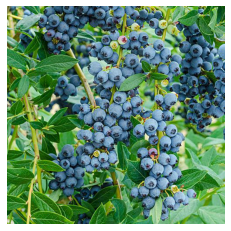

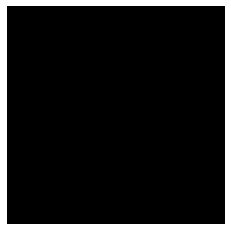

In [ ]:
segment(fcn, '/content/blueberry.jpg')

In [ ]:
!git clone https://github.com/milesial/Pytorch-UNet.git

fatal: destination path 'Pytorch-UNet' already exists and is not an empty directory.


In [ ]:
cd /content/Pytorch-UNet

/content/Pytorch-UNet


[[ 4  0  3]
 [ 4  0  3]
 [ 4  0  3]
 ...
 [11  7  8]
 [ 3  0  0]
 [16 12 13]]


TypeError: ignored

In [ ]:
sudo rm -r data/imgs

UsageError: Line magic function `%sudo` not found.


In [ ]:
#net = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana')
#torch.save(net.state_dict(), 'MODEL.pth')

!python train.py
#!python predict.py -i '/content/IMG-0001-00012.jpg' -o 'output.jpg'



python3: can't open file 'train.py': [Errno 2] No such file or directory
